# Imports and Data Handling

In [39]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import src as tools
#import seaborn as sns

In [40]:
np.random.seed(0)

In [41]:
df = pd.read_csv("C:\\Users\\jeffr\\Desktop\\CS184A\\Project\\FetusHealthML\\Project\\fetal_health.csv")
# df = pd.read_csv("C:\\Users\\sharv\\184\\final\\FetusHealthML\\Project\\fetal_health.csv")
print("Original dataset:",df.shape[0],"datapoints,",df.shape[1],"features")

#As discussed in the project proposal, we will experiment with using only the first 7 features that are actual recordings of
#the patients monitoring.
short_df = df[['baseline value','accelerations','fetal_movement','uterine_contractions'
               ,'light_decelerations','severe_decelerations','prolongued_decelerations']]
print("Shortened Dataset:",short_df.shape[0],"datapoints,",short_df.shape[1],"features")

#
y_labels = df[['fetal_health']]
print("True labels of Dataset:",y_labels.shape)
#Thankfully all the values are numerical, no need to reencode them
# TODO: MAYBE WANT TO NORMALIZE DATASET? CONSIDER DELETING SEVERE_DECELERATIONS COL SINCE ITS ALMOST ALL 0??

Original dataset: 2126 datapoints, 22 features
Shortened Dataset: 2126 datapoints, 7 features
True labels of Dataset: (2126, 1)


In [42]:
#With the dataset prepared, we must split it into training, validation, and testing sets.
#Note: The validation set is really only for the Neural Network model. We will do another split for it seperately
x_train, x_test, y_train, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)
print("Training Set size:",x_train.shape)
print("Training Targt size", y_train.shape)
print("Testing Set size:",x_test.shape)

Training Set size: (1700, 7)
Training Targt size (1700, 1)
Testing Set size: (426, 7)


In [43]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# KNN(small dataset & cross validation)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0
...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0


10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


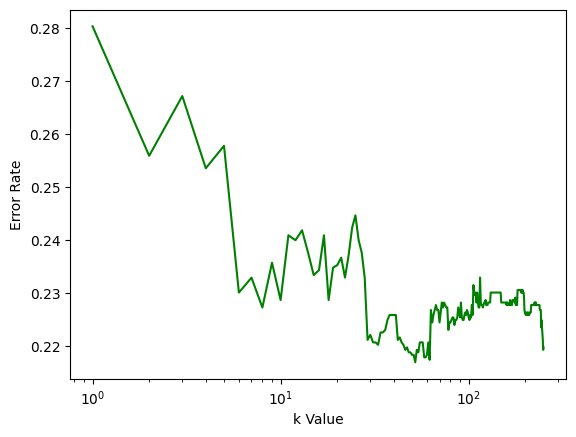

Lowest error rate is 0.21693123446561727 at k = 52
Training Set size: (1700, 7)
Training Targt size (1700, 1)
Testing Set size: (426, 7)
Accuracy score: 0.7863849765258216
F1 score: 0.7175491936055317


c:\Users\jeffr\Desktop\CS184A\Project\FetusHealthML\Project\venv\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


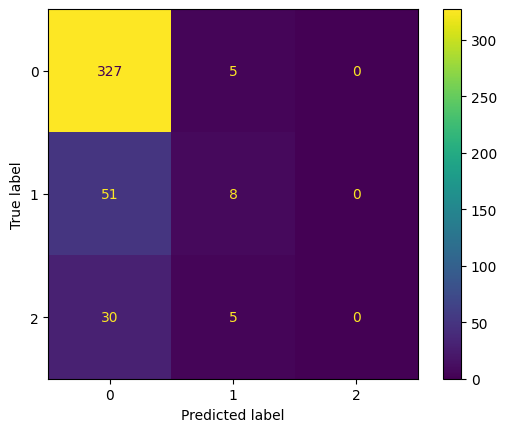

In [44]:
#Using the KNNClassifier from the sklearnknn_classifier.fit(X_train, y_train) library, we will experiment with different values of k.

KNN_crossValidationErrors = [0]*250

x_train = short_df
y_train = y_labels


display(x_train)
x_train = np.array(x_train)
y_train = np.array(y_train)


for k in range(250):
    k = k+1 #1-250 not 0-249
    if(k%25==0):
        print(k/2.5) #Scuffed progress bar
    # Cross-validation with 5 fold
    nFolds = 5
    for iFold in range(nFolds):
        Xti, Xvi, Yti, Yvi = tools.crossValidate(x_train, y_train,nFolds, iFold)
        knnClassifier = KNeighborsClassifier(n_neighbors=k)
        knnClassifier.fit(Xti, Yti)
    
        cross_validation_pred = knnClassifier.predict(Xvi)
    
        cross_validation_accuracy = accuracy_score(Yvi,cross_validation_pred)

        cross_validation_error = 1-cross_validation_accuracy
        KNN_crossValidationErrors[k-1] += cross_validation_error
    KNN_crossValidationErrors[k-1] = KNN_crossValidationErrors[k-1]/nFolds

plt.semilogx(range(1, len(KNN_crossValidationErrors) + 1), KNN_crossValidationErrors, color='g')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

print("Lowest error rate is",min(KNN_crossValidationErrors),"at k =",KNN_crossValidationErrors.index(min(KNN_crossValidationErrors))+1)
# k = KNN_testErrors.index(min(KNN_testErrors))+1 because it's pulling the error rate from a list (starts at 0)
#But k values actually start at k = 1
bestk = KNN_crossValidationErrors.index(min(KNN_crossValidationErrors))+1


#Confusion Matrix for best performing KNN.
x_train, x_test, y_train, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)
print("Training Set size:",x_train.shape)
print("Training Targt size", y_train.shape)
print("Testing Set size:",x_test.shape)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train, y_train)
y_test_pred = knnClassifier.predict(x_test)
matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy score: {}".format(accuracy_score(y_test,y_test_pred)))
print("F1 score: {}".format(f1_score(y_test, y_test_pred,average="weighted")))

# KNN(normal dataset & NO cross validation)

Training Set size: (1700, 21)
Testing Set size: (426, 21)
10
20
30
40
50
60
70
80
90
100


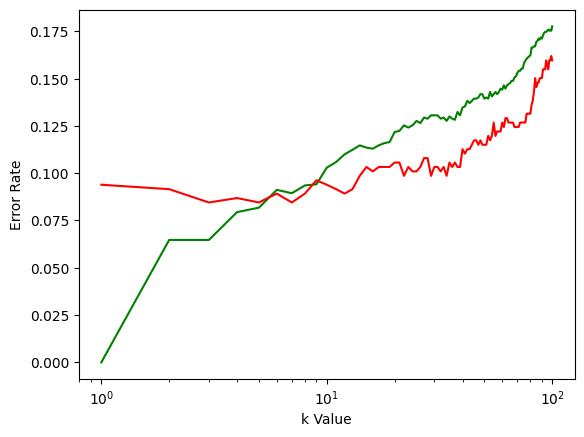

Lowest error rate is 0.08450704225352113 at k = 3
Accuracy: 0.9154929577464789
F1 Score: 0.9138825431980803


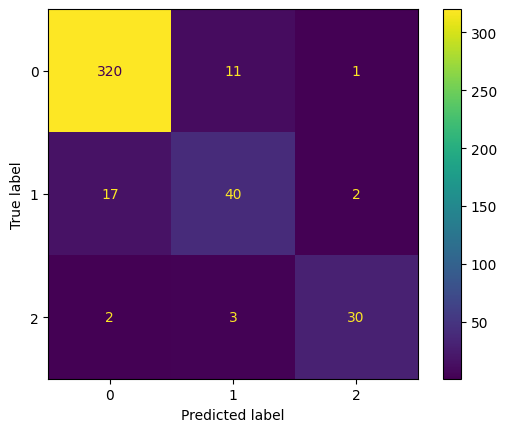

In [45]:
#We will repeat the same process, but with the entire dataset. To save time, I will only test for up to k=100. 
#In all likelihood, the best k value will reveal itself early on
x_train2, x_test2, y_train2, y_test2 = train_test_split(df.loc[:,df.columns!="fetal_health"], y_labels, test_size=0.2,stratify=y_labels)
print("Training Set size:",x_train2.shape)
print("Testing Set size:",x_test2.shape)

KNN_testErrors = [] #index will represent k value. Testing up to k = 100
KNN_trainErrors = []
for k in range(100):
    k = k+1 #1-100, not 0-99
    if(k%10==0):
        print(k) #Scuffed progress bar
    knnClassifier = KNeighborsClassifier(n_neighbors=k)
    knnClassifier.fit(x_train2, y_train2.values.ravel())
    
    y_train_pred2 = knnClassifier.predict(x_train2)
    y_test_pred2 = knnClassifier.predict(x_test2)
    
    train_accuracy2 = accuracy_score(y_train2,y_train_pred2)
    test_accuracy2 = accuracy_score(y_test2,y_test_pred2)
    train_error2 = 1-train_accuracy2
    test_error2 = 1-test_accuracy2
    KNN_trainErrors.append(train_error2)
    KNN_testErrors.append(test_error2)
    
plt.semilogx(range(1, len(KNN_trainErrors) + 1), KNN_trainErrors, color='g')
plt.semilogx(range(1, len(KNN_testErrors) + 1), KNN_testErrors, color='r')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

bestk = KNN_testErrors.index(min(KNN_testErrors))+1
print("Lowest error rate is",min(KNN_testErrors),"at k =",bestk)

knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train2, y_train2.values.ravel())
y_test_pred2 = knnClassifier.predict(x_test2)

matrix = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy: {}".format(accuracy_score(y_test2,y_test_pred2)))
print("F1 Score: {}".format(f1_score(y_test2, y_test_pred2, average="weighted")))

# KNN(normal dataset & cross validation)

Training Set size: (2126, 21)
10
20
30
40
50
60
70
80
90
100


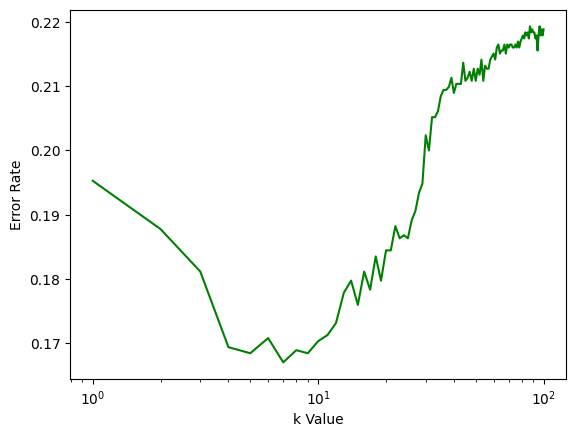

Lowest cross-validation error rate is 0.16705109085887876 at k = 7
Accuracy: 0.892018779342723
F1 Score: 0.8869830418508452


c:\Users\jeffr\Desktop\CS184A\Project\FetusHealthML\Project\venv\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


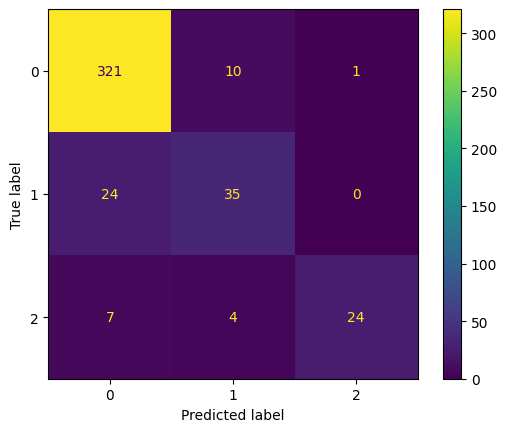

In [46]:
#We will repeat the same process, but with the entire dataset. To save time, I will only test for up to k=100. 
#In all likelihood, the best k value will reveal itself early on
x_train2 = df.loc[:,df.columns!="fetal_health"]
y_train2 = df.loc[:,df.columns=="fetal_health"]
print("Training Set size:",x_train2.shape)

x_train2 = np.array(x_train2)
y_train2 = np.array(y_train2)

KNN_testErrors = [0]*100 #index will represent k value. Testing up to k = 100
KNN_trainErrors = [0]*100
for k in range(100):
    k = k+1 #1-100, not 0-99
    if(k%10==0):
        print(k) #Scuffed progress bar
    nFolds = 5
    for iFold in range(nFolds):
        Xti, Xvi, Yti, Yvi = tools.crossValidate(x_train2, y_train2,nFolds, iFold)
        knnClassifier = KNeighborsClassifier(n_neighbors=k)
        knnClassifier.fit(Xti, Yti)
    
        y_train_pred2 = knnClassifier.predict(Xvi)
    
        train_accuracy2 = accuracy_score(Yvi,y_train_pred2)
        train_error2 = 1-train_accuracy2
        KNN_trainErrors[k-1] += train_error2
    KNN_trainErrors[k-1] = KNN_trainErrors[k-1]/5
    
plt.semilogx(range(1, len(KNN_trainErrors) + 1), KNN_trainErrors, color='g')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

bestk = KNN_trainErrors.index(min(KNN_trainErrors))+1
print("Lowest cross-validation error rate is",min(KNN_trainErrors),"at k =",bestk)

x_train2, x_test2, y_train2, y_test2 = train_test_split(df.loc[:,df.columns!="fetal_health"], y_labels, test_size=0.2,stratify=y_labels)
knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train2, y_train2)
y_test_pred2 = knnClassifier.predict(x_test2)
matrix = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy: {}".format(accuracy_score(y_test2,y_test_pred2)))
print("F1 Score: {}".format(f1_score(y_test2, y_test_pred2, average="weighted")))

Overall, KNN had some decent predicting power. As expected, as more features became considered, KNN's prediction accuracy on testing sets declined significantly. 

## MLP 

In [13]:
#Before creating the models and such, we msut create the training, validation, and testing splits.
#x_temp, x_test, y_temp, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)
#x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2,stratify=y_temp)
x_train, x_test, y_train, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

#Because the labels are 1-indexed (starts at 1), we must subtract everything by 1 to make it 0-indexed
y_train = y_train-1
#y_val = y_val-1
y_test = y_test-1

In [14]:
#With KNN out of the way, we shall use the keras library to build NN models. Hopefully, the NN models will have a higher
#prediction accuracy...
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#We'll start with a simple one
model = keras.Sequential(name="FetusHealthNNmodel1")
model.add(layers.Dense(25, activation='relu',input_dim=7))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))

In [ ]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "FetusHealthNNmodel1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 25)                200       
                                                                 
 dense_23 (Dense)            (None, 12)                312       
                                                                 
 dense_24 (Dense)            (None, 3)                 39        
                                                                 
Total params: 551 (2.15 KB)
Trainable params: 551 (2.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
nFolds = 5
testingCrossValidationError = []
for iFold in range(nFolds):
    Xti, Xvi, Yti, Yvi = tools.crossValidate(x_train, y_train,nFolds, iFold)
    model.fit(Xti, Yti, epochs=5, validation_data=(Xvi, Yvi))
    y_test_pred = np.argmax(model.predict(x_test),axis=1) #to get the prediction based off of the softmax results
    test_accuracy = accuracy_score(y_test,y_test_pred)
    testingCrossValidationError.append(test_accuracy)


Epoch 1/5
43/43 [==============================] - 2s 15ms/step - loss: 2.4707 - accuracy: 0.7257 - val_loss: 0.6725 - val_accuracy: 0.8059
Epoch 2/5
43/43 [==============================] - 0s 6ms/step - loss: 0.7130 - accuracy: 0.7713 - val_loss: 0.6494 - val_accuracy: 0.8059
Epoch 3/5
43/43 [==============================] - 0s 6ms/step - loss: 0.7094 - accuracy: 0.7713 - val_loss: 0.6515 - val_accuracy: 0.8059
Epoch 4/5
43/43 [==============================] - 0s 6ms/step - loss: 0.7074 - accuracy: 0.7713 - val_loss: 0.6763 - val_accuracy: 0.8059
Epoch 5/5
14/14 [==============================] - 0s 3ms/step
Epoch 1/5
43/43 [==============================] - 0s 8ms/step - loss: 0.6990 - accuracy: 0.7757 - val_loss: 0.6717 - val_accuracy: 0.7882
Epoch 2/5
43/43 [==============================] - 0s 6ms/step - loss: 0.6970 - accuracy: 0.7757 - val_loss: 0.6758 - val_accuracy: 0.7882
Epoch 3/5
43/43 [==============================] - 0s 6ms/step - loss: 0.6994 - accuracy: 0.7757 - val

In [ ]:
avgTestAccuracy = sum(testingCrossValidationError)/nFolds
print("Testing Accuracy:",avgTestAccuracy)
print("F1 Score:",f1_score(y_test, y_test_pred,average="weighted"))

Testing Accuracy: 0.7793427230046949
F1 Score: 0.6826960000990994
